##### This model follows the same fine tuning process as the first finetuned model, but is adjusted to have longer maximum lengths for model inputs (both text inputs and targets). The goal of this change is to increase the information the model can gather from the inputs, most of which are likely longer than the allowed maximum lengths of the previous model.

# Imports

In [3]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [5]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf


## Set up model tokenizer

In [6]:
# Using same model checkpoint as first finetuned model

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

## Tokenize data

In [7]:
# Increasing max input and target lengths from first model

max_input_length = 1024
max_target_length = 512

def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=max_input_length, truncation=True
  )

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=max_target_length, truncation=True
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs


tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [8]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

All the layers of TFMT5ForConditionalGeneration were initialized from the model checkpoint at google/mt5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMT5ForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [9]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [15]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=2   #Had to decrease batch size to avoid 'Resource Exhausted' error with larger max lengths for inputs & targets
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=2
)

## Set up model hyperparamaters

In [16]:
num_train_epochs = 8
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [17]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [18]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=8)

Epoch 1/8
106/106 [==============================] - 87s 520ms/step - loss: 14.2550 - val_loss: 7.8276
Epoch 2/8
106/106 [==============================] - 48s 458ms/step - loss: 9.6842 - val_loss: 8.4136
Epoch 3/8
106/106 [==============================] - 49s 462ms/step - loss: 8.2499 - val_loss: 7.1685
Epoch 4/8
106/106 [==============================] - 49s 460ms/step - loss: 7.5850 - val_loss: 6.5331
Epoch 5/8
106/106 [==============================] - 49s 459ms/step - loss: 7.1722 - val_loss: 6.2561
Epoch 6/8
106/106 [==============================] - 49s 459ms/step - loss: 6.9492 - val_loss: 6.0007
Epoch 7/8
106/106 [==============================] - 49s 458ms/step - loss: 6.7651 - val_loss: 5.8719
Epoch 8/8
106/106 [==============================] - 49s 459ms/step - loss: 6.7530 - val_loss: 5.7961


# Visualize model 

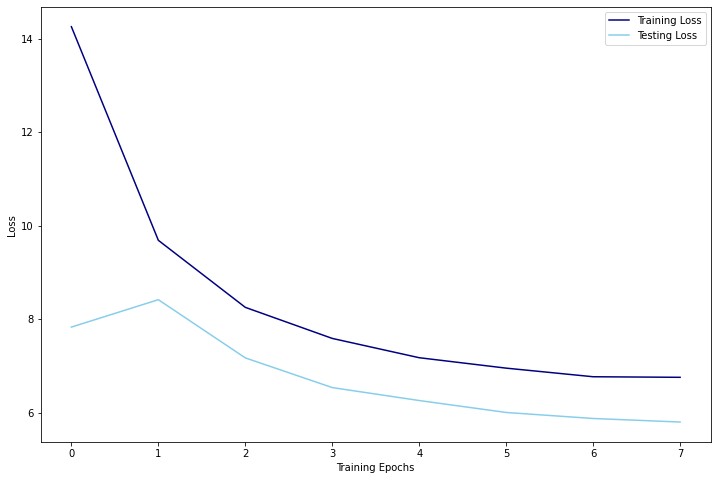

In [19]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data of this model is lower than the loss for the training data, indicating that the model is doing well at adapting to new data. 

# Rouge scores for training data

In [20]:
#Get decoded predictions and labels from model
# code from https://huggingface.co/course/chapter7/5?fw=tf

all_preds = []
all_labels = []
for batch in tqdm(tf_validation):
    predictions = model.generate(**batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

100%|██████████| 12/12 [00:52<00:00,  4.37s/it]


In [21]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 47.72727272727273
recall: 2.9848781771914945
f-measure: 5.616608781296978
***************
rouge2
precision: 4.545454545454546
recall: 0.2808988764044944
f-measure: 0.5291005291005291
***************
rougeL
precision: 43.18181818181818
recall: 2.7230980724794525
f-measure: 5.121559276346482
***************
rougeLsum
precision: 47.72727272727273
recall: 2.9848781771914945
f-measure: 5.616608781296978
***************


# Rouge scores for test data

In [23]:
#Process test data for input to model

tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=2
)

In [24]:
#Get decoded predictions and labels from putting test data through model
# (same process as above)

test_preds = []
test_labels = []
for batch in tqdm(tf_test):
    predictions = model.generate(**batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 30/30 [02:03<00:00,  4.12s/it]


In [25]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 50.0
recall: 2.1834061135371177
f-measure: 4.184100418410041
***************
rouge2
precision: 0.0
recall: 0.0
f-measure: 0.0
***************
rougeL
precision: 50.0
recall: 2.1834061135371177
f-measure: 4.184100418410041
***************
rougeLsum
precision: 50.0
recall: 2.1834061135371177
f-measure: 4.184100418410041
***************


# Example model-generated summaries

In [26]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [27]:
print(rand_indexes)

[12, 21, 50]


In [28]:
#Reference summary example 1
print(test_labels[12])

I Chapter 1-4 The narrator begins his story in the year 1775 with the observation that "It was the best of times, it was the worst of times" and concludes that it was a period in all respects much like the one nearly 70 years later from which the tale is being told.
The narrator observes that there were kings and queens in England and France and that the aristocrats in both countries found little reason to expect any change in their status.
At this time the English Crown received reports of unrest from its American colonies and in France the aristocracy continued its trend of overspending at the expense of its working poor.
Criminals in both countries were dealt harsh physical punishment for even the smallest of crimes.
In England, there were frequent highway robberies and corruption allowed the practice to flourish.
On a particularly foggy night in 1775 the mail coach from London to Dover is struggling up a muddy hill.
The coach's three nervous passengers walk beside the coach in orde

In [29]:
#Model summary example 1
print(test_preds[12])

<extra_id_0>, which would a few thousand thousands of their


In [30]:
#Reference summary example 2
print(test_labels[21])

Dante is deeply discouraged by seeing Virgil so upset, but Virgil recovers as soon as they reach the place where they have to climb, and turns to Dante "with that sweet look that I first saw at the foot of the mountain" (lines 20-21), back in the Dark Wood.
Once again he picks Dante up and lifts him high enough that he can climb on his own, with Virgil's help.
It's the hardest climb they've had yet, and Dante sits down exhausted at the top, but Virgil urges him on.
Sloth won't win him fame.
And Dante pulls himself together and goes on.
They go over the next high, narrow bridge, but can only see the souls down in the ditch (the Seventh Bolgia) when they come to the other side.
There they see shades tormented by serpents.
As they watch, one soul is bitten by a serpent, dissolves into ash, and then re-forms.
It turns out to be a notorious plunderer and thief named Vanni Fucci, who is so ashamed to have Dante see him here that he foretells the coming victory of the Blacks in Florence, just

In [31]:
#Model summary example 2
print(test_preds[21])

<extra_id_0>.
They would a few believe.
They would a


In [32]:
#Reference summary example 3
print(test_labels[50])

Katherine, who is increasingly emotionally unstable, asks Luzhin to come to her aid, citing her father's hospitality to him.
He waves her away contemptuously, openly denying that he knew her father.
He goes immediately to Sonia and accuses her of stealing a one hundred-ruble note from his room during their meeting.
Katherine rushes to her defense, vehemently denying that Sonia would do such a thing.
Sonia is frightened and horrified.
She responds that she didn't take anything and gives him back the ten-ruble note he had given her.
Sonia looks around her in despair and sees the crowd eyeing her with hostility.
Raskolnikov is gazing steadily at her.
In anger at Luzhin's accusations, Katherine searches Sonia's pockets.
In her right pocket she finds a crumpled one hundred-ruble bill.
Katherine still does not believe Sonia is guilty.
She gives a pathetic plea to the crowd to come to her aid.
Suddenly, a voice in the doorway says, How lowdown that is!
It is Lebeziatnikov, who testifies that 

In [33]:
#Model summary example 3
print(test_preds[50])

<extra_id_0>.........


# Evaluation of Model

Based on rouge scores for test data, this model performed worse than the baseline model and the first finetuned model. The trainign rouge scores for this model were improved. The example generated summaries for this model also do not make human readable sense.